TP 3 - Vision por Computadora

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

- (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
- (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1
- (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes. Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.


## Librerías y utilidades
Helpers para cargar el template, armar pirámide de escalas y encapsular la detección con `matchTemplate` + filtros de color (rojo y blanco) y NMS. Se usa un `GaussianBlur` suave; balanceamos hacia la textura del texto y reforzamos el requisito de área/aspecto para evitar tapas.


In [1]:

from pathlib import Path
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt



## Template
Vista rápida del template que usamos para las correlaciones.


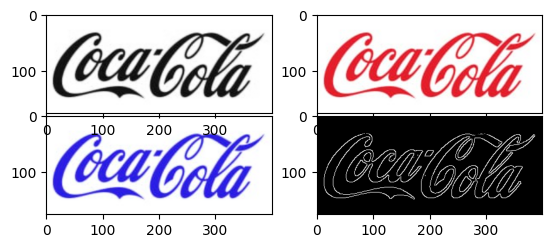

In [2]:
compare_mode_on = False # Set to True to compare different template types
template_path = Path('./template/pattern.png')
template = cv.imread(template_path)
template_canny = cv.Canny(template, 100, 200)
template_gray = cv.cvtColor(template, cv.COLOR_RGB2GRAY)
bgr_template = cv.cvtColor(template, cv.COLOR_RGB2BGR)
hsv_template = cv.cvtColor(template, cv.COLOR_RGB2HSV)

templates = [
    {
        'name': 'Original',
        'img': template
    },
    {
        'name': 'Gray',
        'img': template_gray
    },
    {
        'name': 'BGR',
        'img': bgr_template
    },
    {
        'name':'HSV',
        'img': hsv_template
    }
]
plt.figure()
plt.subplot(1,2,1)
plt.imshow(template)
plt.subplot(1,2,2)
plt.imshow(template_canny, cmap='gray')
plt.subplot(2,2,1)
plt.imshow(template_gray, cmap='gray')
plt.subplot(2,2,2)
plt.imshow(bgr_template)
plt.show()

## Helpers

In [ ]:
def draw_boxes(image, boxes, scores, color=(0, 255, 0)):
    img_draw = image.copy()
    for (x1, y1, x2, y2), s in zip(boxes, scores):
        cv.rectangle(img_draw, (x1, y1), (x2, y2), color, 4)
        text = f"{s:.3f}"
        cv.putText(img_draw, text, (x1, y1 - 5),
                    cv.FONT_HERSHEY_SIMPLEX, 0.6, color, 4)
    return img_draw

def match_edges_with_resized_template(img, template_edges_base, method):
    img_h, img_w = img.shape[:2]
    img_edges = cv.Canny(img, 100, 200)

    t_h, t_w = template_edges_base.shape[:2]
    templ_edges_used = template_edges_base

    # Si el template es más grande que la imagen → reescalar
    if img_h < t_h or img_w < t_w:
        scale = min(img_w / t_w, img_h / t_h)
        new_w = max(1, int(t_w * scale))
        new_h = max(1, int(t_h * scale))
        templ_edges_used = cv.resize(template_edges_base, (new_w, new_h),
                                      interpolation=cv.INTER_AREA)
        t_h, t_w = templ_edges_used.shape[:2]

    res = cv.matchTemplate(img_edges, templ_edges_used, method)
    return res, t_h, t_w

def match_img_multiscale(img, template, scales, method):
    img_h, img_w = img.shape[:2]
    t_h0, t_w0 = template.shape[:2]

    max_val_best = -1.0
    max_loc_best = None
    t_h_best, t_w_best = t_h0, t_w0
    res = None
    for s in scales:
        new_w = int(t_w0 * s)
        new_h = int(t_h0 * s)

        # Descartar escalas ridículas o fuera de límites
        if new_w < 5 or new_h < 5:
            continue
        if new_w > img_w or new_h > img_h:
            continue

        templ_s = cv.resize(template, (new_w, new_h),
                             interpolation=cv.INTER_AREA)

        res = cv.matchTemplate(img, templ_s, method)
        _, max_val, _, max_loc = cv.minMaxLoc(res)

        if max_val > max_val_best:
            max_val_best = max_val
            max_loc_best = max_loc
            t_h_best, t_w_best = new_h, new_w

    return max_val_best, max_loc_best, t_h_best, t_w_best, res

SAT_THRESHOLD =30
GRAY_SCALES = np.linspace(0.7, 1.8, 12)

def compare_whit_matching_template(original,img, template, method, color=(0,255,0)):

    # Imagen retro/B&N
    max_val, max_loc, th_used, tw_used, res = match_img_multiscale(
    img, template, GRAY_SCALES, method)
 
    if res is None:
        return img, None
    
    top_left = max_loc
    bottom_right = (top_left[0] + tw_used, top_left[1] + th_used)

    boxes = np.array([[top_left[0], top_left[1],
                       bottom_right[0], bottom_right[1]]])
    scores = np.array([max_val])

    return draw_boxes(original, boxes, scores, color), res

def compare_whit_matching_edges(original,img,edges, method):

    res, th_used, tw_used = match_edges_with_resized_template(
    img, edges, method)
    _, max_val, _, max_loc = cv.minMaxLoc(res)

    top_left = max_loc
    bottom_right = (top_left[0] + tw_used, top_left[1] + th_used)

    boxes = np.array([[top_left[0], top_left[1],
                       bottom_right[0], bottom_right[1]]])
    scores = np.array([max_val])

    return draw_boxes(original, boxes, scores), res


def multi_detect_logos_with_edge_score(original, img, edges,method, threshold=0.5):
    res, th_used, tw_used = match_edges_with_resized_template(
    img, edges, method)
    
    loc = np.where(res >= threshold)
    for pt in zip(*loc[::-1]):
        print(f"Detected at {pt} with score {res[pt[1], pt[0]]}")
        bottom_right = (pt[0] + tw_used, pt[1] + th_used)
        cv.rectangle(original, pt, bottom_right, (0, 255, 0), 2)
    return original

def detect_gray_scale(img):
    # Saturación para distinguir color vs B/N
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    sat_mean = hsv[..., 1].mean()
    return sat_mean < SAT_THRESHOLD

def gaussian_pyramid(img, levels=4):
    pyr = [img]
    for _ in range(1, levels):
        img = cv.pyrDown(img)
        pyr.append(img)
    return pyr

def match_template_pyramid(img, template, method=cv.TM_CCOEFF_NORMED, levels=4):

    img_pyr = gaussian_pyramid(img, levels)
    best = None  # (score, top_left, bottom_right, level)

    for lvl, img_l in enumerate(img_pyr):
        if img_l.shape[0] < template.shape[0] or img_l.shape[1] < template.shape[1]:
            continue
        res = cv.matchTemplate(img_l, template, method)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        score = min_val if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED] else max_val
        loc = min_loc if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED] else max_loc

        if best is None or ((method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED] and score < best[0]) or
                            (method not in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED] and score > best[0])):
            scale = 2 ** lvl  # porque cada pyrDown divide por 2
            top_left = (int(loc[0] * scale), int(loc[1] * scale))
            br = (int((loc[0] + template.shape[1]) * scale),
                  int((loc[1] + template.shape[0]) * scale))
            best = (score, top_left, br, lvl, res)

    return best  # None si no hubo nivel válido

def draw_pyramid_match(original, image, template, method=cv.TM_CCOEFF_NORMED, levels=4):
    best = match_template_pyramid(image, template, method, levels)
    if best is None:
        print("No match in pyramid")
        return None, None
    _, tl, br, lvl, res = best
    out = original.copy()
    cv.rectangle(out, tl, br, (0, 255, 0), 2)
    return out, res


def laplacian_pyramid(img, levels=4):
    # Devuelve lista de niveles laplacianos y la última gaussiana
    gauss = gaussian_pyramid(img, levels)
    laps = []
    for i in range(levels - 1):
        size = (gauss[i].shape[1], gauss[i].shape[0])
        up = cv.pyrUp(gauss[i + 1], dstsize=size)
        lap = cv.subtract(gauss[i], up)
        laps.append(lap)
    laps.append(gauss[-1])  # nivel más pequeño como tope
    return laps

def match_template_laplacian_pyramid(img, template, method=cv.TM_CCOEFF_NORMED, levels=4):
    img_laps = laplacian_pyramid(img, levels)
    tpl_laps = laplacian_pyramid(template, levels)

    best = None  # (score, tl, br, lvl, res)
    for lvl, (img_l, tpl_l) in enumerate(zip(img_laps, tpl_laps)):
        if img_l.shape[0] < tpl_l.shape[0] or img_l.shape[1] < tpl_l.shape[1]:
            continue
        img_l = img_l.astype(np.float32)
        tpl_l = tpl_l.astype(np.float32)
        res = cv.matchTemplate(img_l, tpl_l, method)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        score = min_val if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED] else max_val
        loc = min_loc if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED] else max_loc
        if best is None or ((method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED] and score < best[0]) or
                            (method not in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED] and score > best[0])):
            scale = 2 ** lvl
            tl = (int(loc[0] * scale), int(loc[1] * scale))
            br = (int((loc[0] + tpl_l.shape[1]) * scale),
                  int((loc[1] + tpl_l.shape[0]) * scale))
            best = (score, tl, br, lvl, res)
    return best

def draw_laplacian_pyramid_match(original,image, template, method=cv.TM_CCOEFF_NORMED, levels=4):
    best = match_template_laplacian_pyramid(image, template, method, levels)
    if best is None:
        print("No match in laplacian pyramid")
        return None, None
    _, tl, br, lvl, res = best
    out = original.copy()
    cv.rectangle(out, tl, br, (255, 0, 0), 2)
    return out, res


def draw_plot(img,res, meth):
    plt.figure()

    # Resultado de coincidencia
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

    # Imagen original con recuadros
    plt.subplot(122),plt.imshow(img)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

    plt.suptitle(meth)
    plt.show()

def draw_multiplot(results, width=20, row_height=2.5):
    n = len(results)
    fig, axes = plt.subplots(n, 2, figsize=(width, row_height * n))
    axes = axes.reshape(n, 2)  # por si n=1
    
    for i, result in enumerate(results):
        pic_name = result['name']
        converter = result['converter']
        case_name = result['case']
        template_name =''
        if case_name == 'template':
            template_name = result['template']
        method = result['method']
        bgr_img = result['boxes']
        detect_point_title = f'{case_name} - Detected Point - {template_name} - {method}'
        matching_result_title = f'{pic_name} - Matching Result - {converter}'
        img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
        res = result['res']

        axes[i, 0].imshow(res, cmap='gray')
        axes[i, 0].set_title(matching_result_title)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img)
        axes[i, 1].set_title(detect_point_title)
        axes[i, 1].axis('off')

    fig.tight_layout()
    plt.show()


## Punto 1: detección única sin falsos positivos





### Exploración de todas las posibilidades de converción, métodos posibles incluyendo pirámide Gaussiana y Laplaciana. (EJECUTAR SOLO PARA COMPARAR NO EN TODOS LOS CASOS)


In [4]:
if compare_mode_on:
    methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
                    'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']


    base_folder = Path('./images')

    executions = [
        {
            'image':'coca_logo_1.png',
            'matches':{
                'None': ['Original','BGR','HSV'],
                'cv.COLOR_RGB2BGR': ['Original','BGR','HSV'],
                'cv.COLOR_RGB2HSV': ['Original','BGR','HSV'],
                'cv.COLOR_RGB2GRAY': ['Gray'],
            }
        },
        {
            'image':'coca_logo_2.png',
            'matches':{
                'None': ['Original','BGR'],
                'cv.COLOR_RGB2BGR': ['Original','BGR','HSV'],
                'cv.COLOR_RGB2HSV': ['Original','BGR','HSV'],
                'cv.COLOR_RGB2GRAY': ['Gray'],
            }
        },
        {
            'image':'coca_retro_1.png',
            'matches':{
                'None': ['Gray','Original','BGR','HSV']
            }
        },
        {
            'image':'coca_retro_2.png',
            'matches':{
                'None': ['Original','BGR','HSV'],
                'cv.COLOR_RGB2BGR': ['Original','BGR','HSV'],
                'cv.COLOR_RGB2HSV': ['Original','BGR','HSV'],
                'cv.COLOR_RGB2GRAY': ['Gray'],    
            }
        },
        {
            'image':'COCA-COLA-LOGO.jpg',
            'matches':{
                'None': ['Original','BGR'],
                'cv.COLOR_RGB2BGR': ['Original','BGR'],
                'cv.COLOR_RGB2HSV': ['Original','BGR'],
                'cv.COLOR_RGB2GRAY': ['Gray'],
            }
        },
        {
            
            'image':'logo_1.png',
            'matches':{
                'None': ['Original','BGR'],
                'cv.COLOR_RGB2BGR': ['Original','BGR'],
                'cv.COLOR_RGB2HSV': ['Original','BGR'],
                'cv.COLOR_RGB2GRAY': ['Gray'],
            }
        },
    ]
    def get_template_by_name(name):
        cv.COLOR_RGB2HSV
        for t in templates:
            if t['name'] == name:
                return t['img']

    for exe in executions:
        image_name = exe['image']
        img = cv.imread(base_folder / image_name)
        results = []
        for converter, selected_templates in exe['matches'].items():
            if converter == 'None':
                converted_img = img
            else:
                converted_img = cv.cvtColor(img, eval(converter))
            for method in methods:
                    boxes,res = compare_whit_matching_edges(img, converted_img, template_canny ,eval(method))
                    results.append({'method': method, 'boxes': boxes, 'res': res,'name': image_name,'converter': converter,'case': 'edges'})    
            for template_name in selected_templates:
                template_img = get_template_by_name(template_name)
                if converted_img.ndim != template_img.ndim:
                    continue
                for method in methods:
                    boxes, res = compare_whit_matching_template(img, converted_img, template_img, eval(method))
                    if res is None:
                        continue
                    results.append({'method': method, 'boxes': boxes, 'res': res,'name': image_name,'converter': converter,'template': template_name,'case': 'template'})
                    out, res_piramid = draw_pyramid_match(img, converted_img, template_img, eval(method), levels=10)
                    if out is not None:
                        results.append({'method': method, 'boxes': boxes, 'res': res_piramid,'name': image_name,'converter': converter,'template': template_name,'case': 'g-piramid'})
                    out, res_laplacian = draw_laplacian_pyramid_match(img, converted_img, template_img, cv.TM_CCOEFF_NORMED, levels=5)
                    if out is not None:
                        results.append({'method': method, 'boxes': boxes, 'res': res_laplacian,'name': image_name,'converter': converter,'template': template_name,'case': 'l-piramid'})

        
        draw_multiplot(results)
    
    
    


### Seleccionamos algoritmos según la imagen

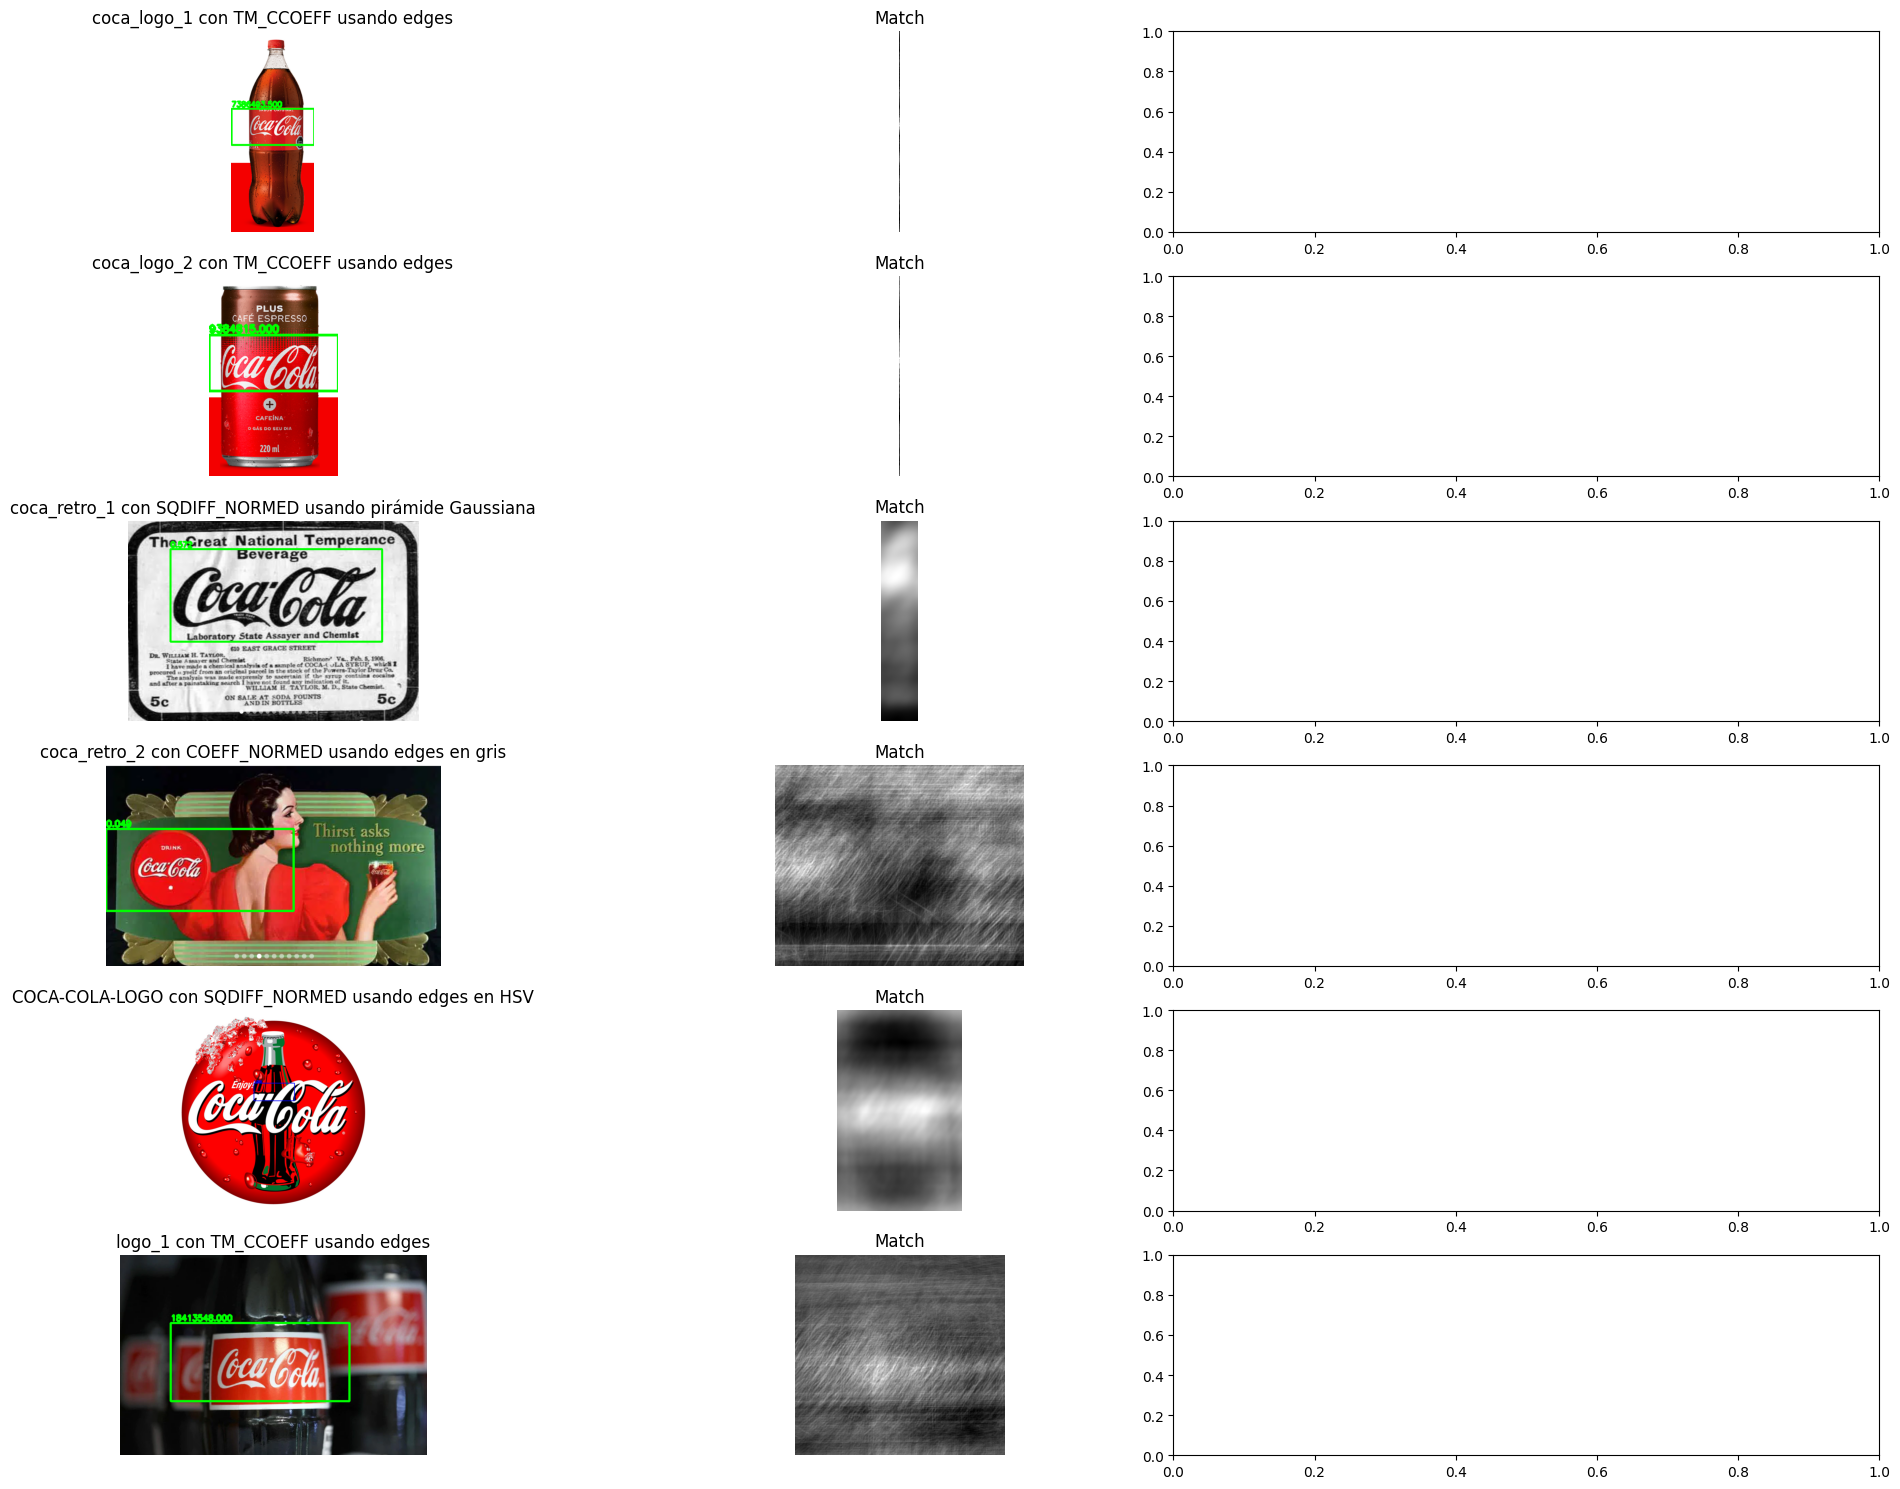

In [5]:

def draw_final_results(results, width=20, row_height=2.5):
    n = len(results)
    fig, axes = plt.subplots(n, 3, figsize=(width, row_height * n))
    if n == 1:
        axes = axes.reshape(1, 3)

    for i, result in enumerate(results):
        method = result['method']
        box_img = result['boxes']
        res = result['res']

        axes[i, 0].imshow(cv.cvtColor(box_img, cv.COLOR_BGR2RGB))
        axes[i, 0].set_title(method)
        axes[i, 0].axis('off')

        cmap = 'gray' if res.ndim == 2 else None
        axes[i, 1].imshow(res, cmap=cmap)
        axes[i, 1].set_title('Match')
        axes[i, 1].axis('off')

    fig.tight_layout()
    plt.show()

results = []
base_path = Path('./images')
coca_logo_1 = cv.imread(base_path / 'coca_logo_1.png')
boxes, res = compare_whit_matching_edges(coca_logo_1, coca_logo_1, template_canny ,cv.TM_CCOEFF)
results.append({'method': 'coca_logo_1 con TM_CCOEFF usando edges', 'boxes': boxes, 'res': res})

coca_logo_2 = cv.imread(base_path /'coca_logo_2.png')
coca_logo_2_gray = cv.cvtColor(coca_logo_2, cv.COLOR_RGB2GRAY)
boxes, res = compare_whit_matching_edges(coca_logo_2, coca_logo_2_gray, template_canny ,cv.TM_CCOEFF)
results.append({'method': 'coca_logo_2 con TM_CCOEFF usando edges', 'boxes': boxes, 'res': res})

coca_retro_1 = cv.imread(base_path / 'coca_retro_1.png')
#COEFF TEMPLATE ORIGINAL, COEFF G PIRAMID, COEFF IPIRAMID MEJOR RESULTADO I-PIRAMID SQDIFF_NORMED

boxes, res = compare_whit_matching_template(coca_retro_1, coca_retro_1, template, cv.TM_CCOEFF_NORMED)
results.append({'method': 'coca_retro_1 con SQDIFF_NORMED usando pirámide Gaussiana', 'boxes': boxes, 'res': res})

coca_retro_2 = cv.imread(base_path /'coca_retro_2.png')
coca_retro_2_gray = cv.cvtColor(coca_retro_2, cv.COLOR_RGB2GRAY)
boxes, res = compare_whit_matching_edges(coca_retro_2, coca_retro_2_gray, template_canny ,cv.TM_CCOEFF_NORMED)
results.append({'method': 'coca_retro_2 con COEFF_NORMED usando edges en gris', 'boxes': boxes, 'res': res})

coca_cola_logo = cv.imread(base_path /'COCA-COLA-LOGO.jpg')
coca_cola_logo_hsv = cv.cvtColor(coca_cola_logo, cv.COLOR_RGB2HSV)
boxes, res = compare_whit_matching_template(coca_cola_logo, coca_cola_logo_hsv, template ,cv.TM_SQDIFF_NORMED, color=(255,0,0))
coca_cola_logo_result_with_boxes = cv.cvtColor(boxes, cv.COLOR_HSV2RGB)
results.append({'method': 'COCA-COLA-LOGO con SQDIFF_NORMED usando edges en HSV', 'boxes': boxes, 'res': res})

logo_1 = cv.imread(base_path /'logo_1.png')
boxes, res = compare_whit_matching_edges(logo_1,logo_1, template_canny ,cv.TM_CCOEFF)
results.append({'method': 'logo_1 con TM_CCOEFF usando edges', 'boxes': boxes, 'res': res})



draw_final_results(results)


## Punto 2: múltiples detecciones en `coca_multi.png`
Solo se evalúa `coca_multi.png`


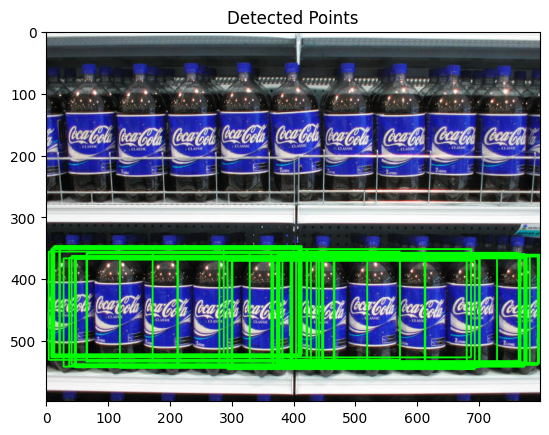

In [ ]:

img_rgb = cv.imread(base_path / 'coca_multi.png')
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

res, th_used, tw_used = match_edges_with_resized_template(img_gray, template_canny, cv.TM_CCOEFF_NORMED)
max_val = res.max()
thr = max_val * 0.85 
loc = np.where(res >= thr)
for pt in zip(*loc[::-1]):
    br = (pt[0] + tw_used, pt[1] + th_used)
    cv.rectangle(img_rgb, pt, br, (0, 255, 0), 2)


plt.figure()
plt.imshow(img_rgb)
plt.title('Detected Points')
plt.show()